# Classifying newswires: a multi-class classification example

This notebook is based on the code samples found in Chapter 4, Section 4.2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) and hosted on https://github.com/fchollet/deep-learning-with-python-notebooks.


In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
tf.__version__

'2.8.0'

In the previous section we saw how to classify vector inputs into two mutually exclusive classes using a densely-connected neural network. 
But what happens when you have more than two classes? 

In this section, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many 
classes, this problem is an instance of **multi-class classification**, and since each data point should be classified into only one 
category, the problem is more specifically an instance of **single-label, multi-class classification**. If each data point could have 
belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

## The Reuters dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, 
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each 
topic has at least 10 examples in the training set.


Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

In [4]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)


Like with the IMDB dataset, the argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the 
data.


We have 8,982 training examples and 2,246 test examples:

In [5]:
len(train_data)

8982

In [6]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [7]:
train_data[0][:10]

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207]

Here's how you can decode it back to words, in case you are curious:

In [8]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [9]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

In [10]:
train_labels[0]

3

According to https://github.com/keras-team/keras/issues/12072, the list of topics is:

In [11]:
topics = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

So, the training sample 0 has the topic label 'earn'. Keras will use the topic number only, the labels are for our reference.

## Preparing the data

We can vectorize the data with the exact same code as in our previous notebook:

In [12]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

To vectorize the labels we could just cast the label list as an integer tensor; we will look at this later on.

For now, we will use **one-hot encoding**.


One-hot encoding is a widely used format for categorical data, also called "categorical encoding". 
In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

In [13]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras:

In [14]:
from tensorflow.keras.utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Building our network


This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to 
classify short snippets of text. There is however a new constraint here: **the number of output classes has gone from 2 to 46**, i.e. the 
dimensionality of the output space is much larger. 

In a stack of `Dense` layers like what we were using, each layer can only access information present in the output of the previous layer. 
If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each 
layer can potentially become an **information bottleneck**. In our previous example, we were using 16-dimensional intermediate layers, but a 
16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, 
permanently dropping relevant information.


For this reason we will use larger layers. Let's go with 64 units:

In [15]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))


There are two other things you should note about this architecture:

* We are ending the network with a `Dense` layer of size 46. This means that for each input sample, our network will output a 
46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* The last layer uses a `softmax` activation. It means that the network will 
output a _probability distribution_ over the 46 different output classes, i.e. for every input sample, the network will produce a 
46-dimensional output vector where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.


The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions: 
in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the 
distance between these two distributions, we train our network to output something as close as possible to the true labels.

In [16]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 46)                2990      
                                                                 
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


## Validating our approach

Let's set apart 1,000 samples in our training data to use as a validation set. To ensure that there is no bias on the partition, we will do a random partition.

In [18]:
import random
random.seed(1232)

In [19]:
data_indices = list(range(len(x_train)))
random.shuffle(data_indices)

In [20]:
x_val = x_train[data_indices[:1000]]
partial_x_train = x_train[data_indices[1000:]]

y_val = one_hot_train_labels[data_indices[:1000]]
partial_y_train = one_hot_train_labels[data_indices[1000:]]

Now let's train our network for 20 epochs:

In [21]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 4s 59ms/step - loss: 2.5403 - accuracy: 0.5288 - val_loss: 1.6467 - val_accuracy: 0.6630
Epoch 2/20
16/16 [==============================] - 0s 25ms/step - loss: 1.3497 - accuracy: 0.7186 - val_loss: 1.3241 - val_accuracy: 0.7050
Epoch 3/20
16/16 [==============================] - 0s 26ms/step - loss: 1.0004 - accuracy: 0.7889 - val_loss: 1.1848 - val_accuracy: 0.7390
Epoch 4/20
16/16 [==============================] - 0s 26ms/step - loss: 0.7814 - accuracy: 0.8396 - val_loss: 1.1258 - val_accuracy: 0.7470
Epoch 5/20
16/16 [==============================] - 0s 28ms/step - loss: 0.6215 - accuracy: 0.8752 - val_loss: 1.0593 - val_accuracy: 0.7630
Epoch 6/20
16/16 [==============================] - 0s 31ms/step - loss: 0.4985 - accuracy: 0.9012 - val_loss: 1.0170 - val_accuracy: 0.7780
Epoch 7/20
16/16 [==============================] - 0s 26ms/step - loss: 0.4054 - accuracy: 0.9182 - val_loss: 1.0157 - val_accuracy: 0.7790
Epoch 8/20
16

Let's display its loss and accuracy curves:

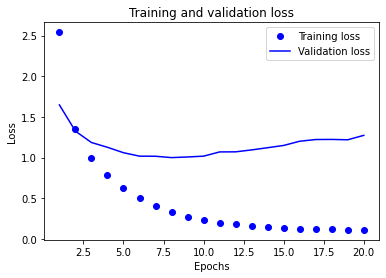

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

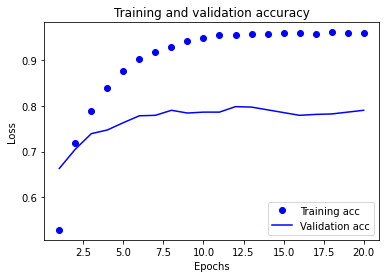

In [23]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

It seems that the network performance on the validation data starts to drop at 8 epochs. We could train a new network from scratch for 8 epochs. Alternatively we can use Keras to train until the loss of the validation set increases. We can do this by adding a **call back function** that executes at the end of every epoch and forces to stop training:

In [24]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [25]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [26]:
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=512,
          validation_data=(x_val, y_val),
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2)])

Epoch 1/20
16/16 [==============================] - 1s 31ms/step - loss: 2.7479 - accuracy: 0.4994 - val_loss: 1.8315 - val_accuracy: 0.6360
Epoch 2/20
16/16 [==============================] - 0s 17ms/step - loss: 1.4640 - accuracy: 0.7025 - val_loss: 1.3693 - val_accuracy: 0.7020
Epoch 3/20
16/16 [==============================] - 0s 18ms/step - loss: 1.0619 - accuracy: 0.7725 - val_loss: 1.2237 - val_accuracy: 0.7370
Epoch 4/20
16/16 [==============================] - 0s 18ms/step - loss: 0.8257 - accuracy: 0.8291 - val_loss: 1.1311 - val_accuracy: 0.7450
Epoch 5/20
16/16 [==============================] - 0s 21ms/step - loss: 0.6609 - accuracy: 0.8627 - val_loss: 1.0682 - val_accuracy: 0.7550
Epoch 6/20
16/16 [==============================] - 0s 19ms/step - loss: 0.5236 - accuracy: 0.8914 - val_loss: 1.0470 - val_accuracy: 0.7560
Epoch 7/20
16/16 [==============================] - 0s 18ms/step - loss: 0.4221 - accuracy: 0.9149 - val_loss: 1.0306 - val_accuracy: 0.7660
Epoch 8/20
16

In the above code, we set an early stopping call back function that monitors the value of the validation loss so that training stop when the validation loss increases (`mode='mim'`). We set the value of patience to 2, meaning that we wait until the validation loss increases in 2 epochs. This prevents stopping too early because of spurious peaks early in the training.

In [27]:
results = model.evaluate(x_test, one_hot_test_labels)
results

71/71 [==============================] - 0s 4ms/step - loss: 0.9840 - accuracy: 0.7952


[0.9839953184127808, 0.7951914668083191]


Our approach reaches an accuracy of ~79%. With a balanced binary classification problem, the accuracy reached by a purely random classifier 
would be 50%. In our case, with 46 classes and balanced data, the accuracy reached by a purely random classifier would be 1 / 46 = 0.0217. Our classifier is clearly much better than that, but is our data set balanced?

A simple count of the labels in the training set reveals that the data are very imbalanced, and category 3 is by far the most frequent:

In [28]:
from collections import Counter
c = Counter(train_labels)
c

Counter({0: 55,
         1: 432,
         2: 74,
         3: 3159,
         4: 1949,
         5: 17,
         6: 48,
         7: 16,
         8: 139,
         9: 101,
         10: 124,
         11: 390,
         12: 49,
         13: 172,
         14: 26,
         15: 20,
         16: 444,
         17: 39,
         18: 66,
         19: 549,
         20: 269,
         21: 100,
         22: 15,
         23: 41,
         24: 62,
         25: 92,
         26: 24,
         27: 15,
         28: 48,
         29: 19,
         30: 45,
         31: 39,
         32: 32,
         33: 11,
         34: 50,
         35: 10,
         36: 49,
         37: 19,
         38: 19,
         39: 24,
         40: 36,
         41: 30,
         42: 13,
         43: 21,
         44: 12,
         45: 18})

A **majority baseline** classifier would classify all newswires with the most popular category, in our case category 3. The accuracy of this majority baseline on the test data is still much lower than with our system:

In [29]:
float(np.sum(np.array(test_labels) == 3)) / len(test_labels)

0.3619768477292965

## Generating predictions on new data

We can verify that the `predict` method of our model instance returns a probability distribution over all 46 topics. Let's generate topic 
predictions for all of the test data:

In [30]:
predictions = model.predict(x_test)

Each entry in `predictions` is a vector of length 46:

In [31]:
predictions[0].shape

(46,)

The actual prediction values for the first sample are:

In [32]:
predictions[0]

array([4.81940748e-04, 7.14939088e-05, 2.01029638e-06, 9.09825683e-01,
       7.41573125e-02, 1.65734764e-06, 6.76152049e-05, 3.28907072e-06,
       6.63873833e-03, 9.95740902e-06, 9.86924169e-06, 6.25286833e-04,
       9.43591003e-05, 1.20320066e-04, 7.18400497e-06, 6.70056324e-05,
       8.90994153e-04, 3.96422110e-05, 2.16507669e-05, 1.53746409e-03,
       2.38221372e-03, 1.09865190e-03, 1.11930410e-06, 1.80595278e-04,
       1.15412104e-06, 3.15179059e-05, 7.34981177e-06, 1.52728899e-06,
       2.75788443e-05, 3.31491814e-04, 1.11462461e-04, 2.44608036e-05,
       1.50123218e-04, 1.46120030e-04, 3.65709639e-05, 4.50036059e-05,
       3.70592228e-04, 5.58328138e-05, 4.77607273e-06, 2.12470215e-04,
       5.57574131e-05, 3.35196455e-05, 8.97872269e-06, 5.35629351e-06,
       1.70991188e-06, 5.83574149e-07], dtype=float32)

The coefficients in this vector sum to 1:

In [33]:
np.sum(predictions[0])

1.0

The largest entry is the predicted class, i.e. the class with the highest probability:

In [34]:
np.argmax(predictions[0])

3

## A different way to handle the labels and the loss

We mentioned earlier that another way to encode the labels would be to cast them as an integer tensor, like such:

In [35]:
partial_y_train = np.array(train_labels[data_indices[1000:]])
y_val = np.array(train_labels[data_indices[:1000]])
y_test = np.array(test_labels)


The only thing it would change is the choice of the loss function. Our previous loss, `categorical_crossentropy`, expects the labels to 
follow a categorical encoding. With integer labels, we should use `sparse_categorical_crossentropy`.

This new loss function is still mathematically the same as `categorical_crossentropy`; it just has a different interface:

In [36]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=512,
          validation_data=(x_val, y_val),
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2)])

Epoch 1/20
16/16 [==============================] - 1s 32ms/step - loss: 2.6327 - acc: 0.5291 - val_loss: 1.7484 - val_acc: 0.6540
Epoch 2/20
16/16 [==============================] - 0s 17ms/step - loss: 1.3888 - acc: 0.7071 - val_loss: 1.3648 - val_acc: 0.6970
Epoch 3/20
16/16 [==============================] - 0s 17ms/step - loss: 1.0300 - acc: 0.7767 - val_loss: 1.2316 - val_acc: 0.7320
Epoch 4/20
16/16 [==============================] - 0s 21ms/step - loss: 0.8106 - acc: 0.8289 - val_loss: 1.1413 - val_acc: 0.7480
Epoch 5/20
16/16 [==============================] - 0s 20ms/step - loss: 0.6468 - acc: 0.8671 - val_loss: 1.0879 - val_acc: 0.7540
Epoch 6/20
16/16 [==============================] - 0s 16ms/step - loss: 0.5149 - acc: 0.8953 - val_loss: 1.0646 - val_acc: 0.7590
Epoch 7/20
16/16 [==============================] - 0s 18ms/step - loss: 0.4161 - acc: 0.9136 - val_loss: 1.0264 - val_acc: 0.7790
Epoch 8/20
16/16 [==============================] - 0s 18ms/step - loss: 0.3390 - a

## On the importance of having sufficiently large intermediate layers


We mentioned earlier that since our final outputs were 46-dimensional, we should avoid intermediate layers with much less than 46 hidden 
units. Now let's try to see what happens when we introduce an information bottleneck by having intermediate layers significantly less than 
46-dimensional, e.g. 4-dimensional.

In [38]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val),
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2)])

Epoch 1/20
63/63 [==============================] - 1s 10ms/step - loss: 3.3531 - accuracy: 0.0402 - val_loss: 2.8126 - val_accuracy: 0.1710
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 2.1847 - accuracy: 0.5198 - val_loss: 1.8798 - val_accuracy: 0.5500
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1.6079 - accuracy: 0.5809 - val_loss: 1.7017 - val_accuracy: 0.5560
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.4490 - accuracy: 0.5948 - val_loss: 1.6841 - val_accuracy: 0.5640
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 1.3709 - accuracy: 0.6107 - val_loss: 1.6721 - val_accuracy: 0.5700
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 1.3154 - accuracy: 0.6260 - val_loss: 1.6717 - val_accuracy: 0.5840
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 1.2285 - accuracy: 0.6678 - val_loss: 1.6296 - val_accuracy: 0.6180
Epoch 8/20
63/63 


Our network now seems to peak at ~71% test accuracy, an 8% absolute drop. This drop is mostly due to the fact that we are now trying to 
compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is 
too low-dimensional. The network is able to cram _most_ of the necessary information into these 8-dimensional representations, but not all 
of it.

## Further experiments

* Try using larger or smaller layers: 32 units, 128 units...
* We were using two hidden layers. Now try to use a single hidden layer, or three hidden layers.

## Wrapping up


Here's what you should take away from this example:

* If you are trying to classify data points between N classes, your network should end with a `Dense` layer of size N.
* In a single-label, multi-class classification problem, your network should end with a `softmax` activation, so that it will output a 
probability distribution over the N output classes.
* **Categorical crossentropy** is almost always the loss function you should use for such problems. It minimizes the distance between the 
probability distributions output by the network, and the true distribution of the targets.

* There are two ways to handle labels in multi-class classification:
    1. Encoding the labels via "categorical encoding" (also known as "one-hot encoding") and using `categorical_crossentropy` as your loss 
function.
    2. Encoding the labels as integers and using the `sparse_categorical_crossentropy` loss function.
* If you need to classify data into a large number of categories, then you should avoid creating information bottlenecks in your network by having 
intermediate layers that are too small.